<a href="https://colab.research.google.com/github/vmacf/redes_neurais/blob/master/RBF_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural de Base Radial (RBF)

1ª Etapa: Inicialização dos grupos com K-Means

In [0]:
import numpy as np
import matplotlib.pyplot as plt


def kmeans(X, k):
  
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- vetor de características da entrada
        k {int} -- número de grupos
    
    Returns:
        ndarray -- retorna um array com os centros dos grupos
    """

    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False

    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)

        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)

        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()

    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])

    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

    return clusters, stds


  
  




Definição da função de base radial

In [0]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

2ª Etapa - Treinamento de uma Rede Neural

In [0]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k #grupos
        self.lr = lr 
        self.epochs = epochs #número de iterações
        self.rbf = rbf
        self.inferStds = inferStds #se vai calcular o tamanho do cluster (std)

        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                loss = (y[i] - F).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error

    def predict(self, X):
        y_pred = []
        error = 0
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
            
            
        return np.array(y_pred)



Executando a Rede Neural

error:  0.636121028130348


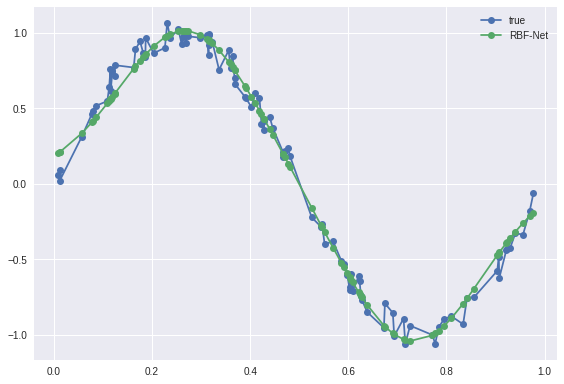

In [0]:
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = RBFNet(lr=1e-2, k=2, inferStds=True)
rbfnet.fit(X, y)

y_pred = rbfnet.predict(X)

errorabs = abs(y-y_pred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))


plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

Executando com Base de Dados

In [0]:
data = 'train-mod.csv'
sigma = 1.2
itergd = 300


dataread = np.genfromtxt(data, delimiter=',')[1:,1:]

alldata = []
for i in range(len(dataread)):
    if np.isnan(dataread[i,-2]):
		    continue
    alldata.append(dataread[i])

alldata = np.asarray(alldata)

#dividing data
trainparam = alldata[:600,1:]
trainlabel = alldata[:600,0]

testparam = alldata[600:,1:]
testlabel = alldata[600:,0]

###############
#normalization#
###############

std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
    std[i] = np.std(trainparam[:,i])
    rata[i] = np.mean(trainparam[:,i])
    trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
	  testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]

  
rbfnet = RBFNet(lr=1e-2, k=2, inferStds=True)
rbfnet.fit(trainparamnorm, trainlabel)

y_pred = rbfnet.predict(testparamnorm)

errorabs = abs(y-y_pred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))

TabError: ignored

# Descrição Mini Projeto

1 - Calcular o taxa de erro no conjunto de teste na RBF utilizando a base de dados train-mod.csv

2- Calcular a taxa de erro usando 3 funções de Base Radial
a) Gaussiana
b) Multiquadrática
c) Multiquadrática Inversa
